### Deep Convolutional Generative Adversarial Network

To run this code open in Google Colab, since a GPU is required for GAN training.

This notebook shows a GAN example using the AGN from the Garon (2019) catalog as the training set.  
To train on a different dataset, simply load a different .npy file at the start.  
Garon sources are typically samller than in FRI/IICAT, CoNFIG and Proctor, so it is possible to crop the images to 56x56 without chopping off part of the source - which has been done here.  
When working with the other datasets images are resized to 56x56 rather than cropped.

Contents:

1. Data loaded, sigma-clipped, cropped/resized & augmented to create training dataset.
2. Define generator and discriminator models.
3. Define loss functions for both models.
4. Define training loop.
5. Define training parameters (optimizers, gif seed, model checkpoints, number of epochs).
6. Train the model.
7. Create loss plot and training gif.
8. Plot example training set of images.



In [35]:
# Import required modules
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from skimage.transform import resize
import os
import PIL
from tensorflow.keras import layers
from astropy import stats
import time
from IPython import display
import sys
from google.colab import drive

2.2.0-rc2


In [36]:
# Mount google drive to load the agn data set
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
## Load and pepare the dataset

# Load data
train_images = np.load('/content/drive/My Drive/University of Birmingham/Year 4/Project/Data/garon-combined.npy', allow_pickle=True)
train_images = train_images[0]

# train_images = np.load('/content/drive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_fr2.npy', allow_pickle=True)
num_images, size, _ = train_images.shape

sigma = 3
for i in range(num_images):
    _, median, std = stats.sigma_clipped_stats(train_images[i], sigma=sigma)
    train_images[i][train_images[i] < median+sigma*std] = median+sigma*std

# Crop to 56x56 (ok to crop Garon images since objects are smaller...)
crop_size = 56
train_images = train_images[:,size//2-crop_size//2:size//2+crop_size//2,size//2-crop_size//2:size//2+crop_size//2]

# Resize images to 56x56
# train_images_resized = np.empty((num_images, 56, 56))
# for i in range(num_images):
#     train_images_resized[i] = resize(train_images[i], (56,56))
# train_images = train_images_resized

# Normalise images to [-1,1]
for i in range(num_images):
    train_images[i] = 2*(train_images[i]-np.min(train_images[i]))/np.ptp(train_images[i])-1

def update_progress(process, progress):
    # Simple progress bar for long loops (e.g. data loading/augmentation)
    block = int(round(10*progress))
    text = "\rProgress: [{}] {:.3f}% {}".format( "#"*block + "-"*(10-block), progress*100, process)
    sys.stdout.write(text)
    sys.stdout.flush()

# Augment images with rotations and flips
def augment_data(data,size):
    rotations = size//len(data) # rotations per image
    angles = np.linspace(0, 360, rotations)
    act_size = rotations*len(data)
    xpix, ypix = data.shape[1:]
    training_set = np.empty((act_size, xpix, ypix))
    for i in range(len(data)):
        for j in range(len(angles)):
            if j % 2 == 0: training_set[i*len(angles)+j,:,:] = rotate(np.fliplr(data[i,:,:]), angles[j], reshape=False, cval=-1)
            else: training_set[i*len(angles)+j,:,:] = rotate(data[i,:,:], angles[j], reshape=False, cval=-1)
        update_progress('Augmenting dataset', (i+1)/len(data))
    return training_set

# Augment images with rotations and flips
train_images = augment_data(train_images, 60000)

# Respahe data array to 4D, and type float32
train_images = train_images.reshape(train_images.shape[0], 56, 56, 1).astype('float32')

BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Progress: [##########] 100.000% Augmenting dataset

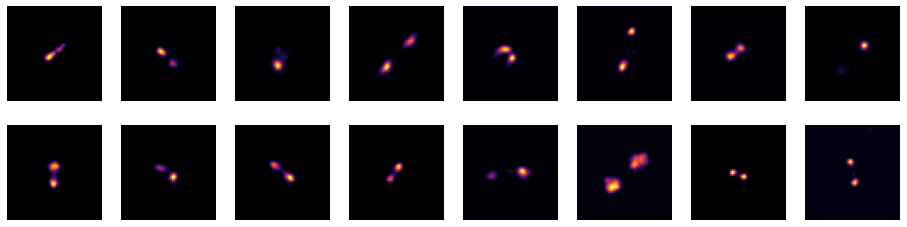

In [38]:
# Plot real data (random selection of 16 images in set)
fig = plt.figure(figsize=(16,4))
rand_indices = np.random.randint(len(train_images), size=16)
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(train_images[rand_indices[i],:,:,0], cmap='inferno')
    plt.axis('off')
plt.show()

In [0]:
## Create the generator and discriminator models

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 512)))
    assert model.output_shape == (None, 7, 7, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 56, 56, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Loss functions for each model

Discriminator loss:  
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

Generator loss:  
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
## Define the loss functions and optimizers for both models

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define the training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
## Define the training loop

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [0]:
def train(dataset, epochs):
    start_time = time.time()
    start_epoch = int(epoch)

    image_save_loc = './images{}_{}'.format(start_epoch, start_epoch+epochs)
    if not os.path.isdir(image_save_loc): os.mkdir(image_save_loc)
    generate_and_save_images(generator, epoch, seed, image_save_loc)
    print('Starting from epoch {}'.format(start_epoch))

    train_g_loss_results, train_d_loss_results = [], []

    while epoch < start_epoch+epochs:
        epoch.assign_add(1)
        start = time.time()

        epoch_g_loss_avg, epoch_d_loss_avg = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

        for image_batch in dataset:
            batch_g_loss, batch_d_loss = train_step(image_batch)
            epoch_g_loss_avg(batch_g_loss)
            epoch_d_loss_avg(batch_d_loss)

        train_g_loss_results.append(epoch_g_loss_avg.result())
        train_d_loss_results.append(epoch_d_loss_avg.result())

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed, image_save_loc)

        # Save the model every 200 epochs
        if (epoch) % 200 == 0:
            checkpoint_prefix = os.path.join(checkpoint_dir, "epoch{}".format(int(epoch)))
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {:.3f} sec'.format(int(epoch), time.time()-start))
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, image_save_loc)
    print('Total time for {} -> {} epochs was {:.3f} mins'.format(start_epoch, int(epoch), (time.time()-start_time)/60))
    print('Average time per epoch: {:.3f} seconds'.format((time.time()-start_time)/epochs))

    return train_g_loss_results, train_d_loss_results
  
def generate_and_save_images(model, epoch, test_input, save_loc):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(16,4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 8, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='inferno')
        plt.axis('off')

    plt.savefig(save_loc+'/image_at_epoch_{:04d}.png'.format(int(epoch)))
    plt.show()

In [0]:
## Setup test parameters and create save checkpoints

generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16
# seed and epoch need to be 'trackable' to save in checkpoint, e.g. tf.Variables
seed = tf.Variable(tf.random.normal([num_examples_to_generate, noise_dim]))
epoch = tf.Variable(0)

'''
Creates a checkpoint, storing the weights and variables of the generator and
discriminator models, so can restore the models to a previous state to run for 
more epochs, or if runtime is interrupted.
'''

checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 seed=seed,
                                 epoch=epoch)

#checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
#status = checkpoint.restore(checkpoint_dir+'/epoch500-10')

## Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

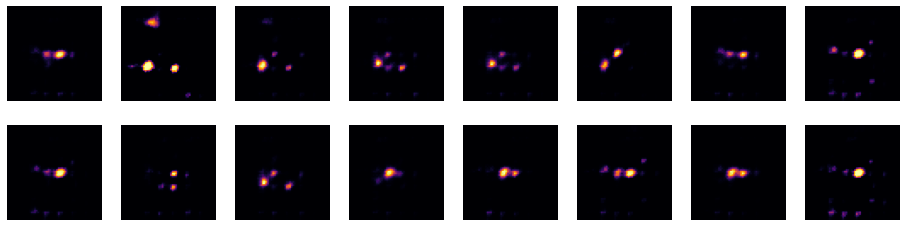

Time for epoch 22 is 79.943 sec


In [0]:
## Train the model
epochs = 100
g_loss, d_loss = train(train_dataset, epochs)

In [0]:
# Plot evolution of loss functions
fig = plt.figure(figsize=(8,6))
fig.patch.set_facecolor('w')
n = len(g_loss)
plt.plot(range(1,n+1),g_loss, label='g')
plt.plot(range(1,n+1),d_loss, label='d')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
## Function to create and save training gif

def create_gif(save_loc, image_loc):
    # Use imageio to create an animated gif using the images saved during training.
    anim_file = save_loc+'{}_{}.gif'.format(int(epoch)-epochs,int(epoch))
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(image_loc+'image*.png')
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

save_loc = './'
anim_file = create_gif(save_loc, './images{}_{}/'.format(int(epoch)-epochs, int(epoch)))

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

## Generate training set from trained generator 



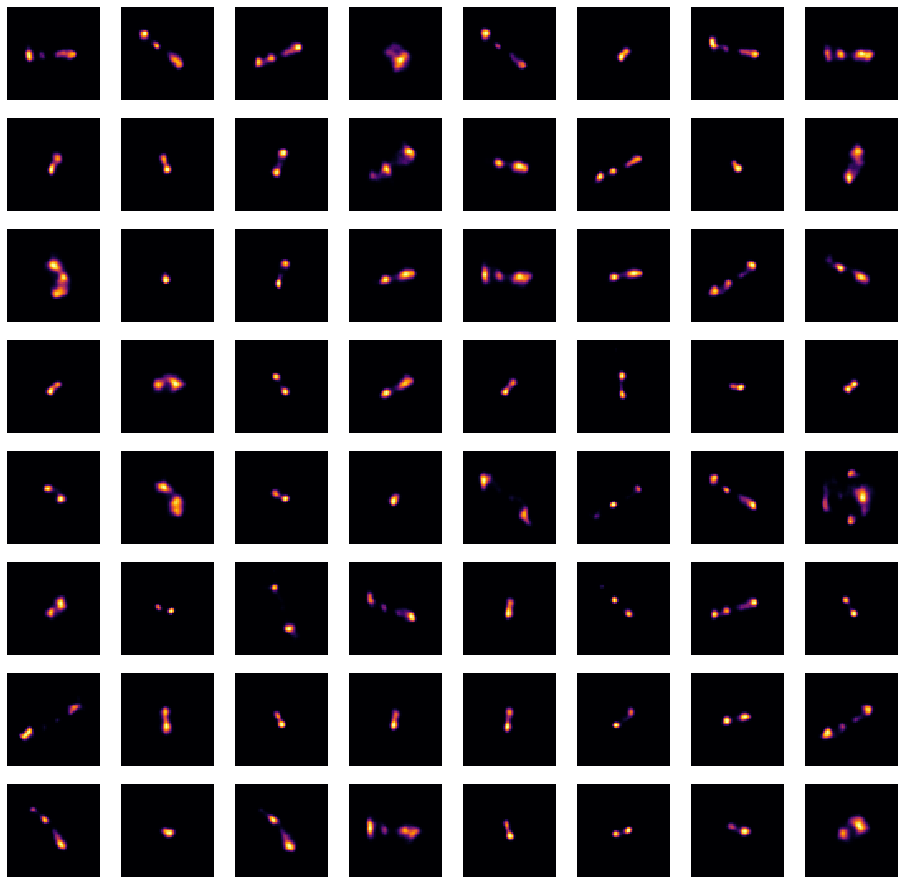

In [0]:
def generate_images(model, num):
    noise_input = tf.random.normal([num, noise_dim])
    # Notice `training` is set to False, so all layers run in inference mode (batchnorm).
    predictions = model(noise_input, training=False)
    n = predictions.shape[0]
    cols = 8
    rows = (n-1)//cols+1
    fig = plt.figure(figsize=(16,2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='inferno')
        plt.axis('off')
    plt.show()

generate_images(generator, 64)